# День четвертый - нейросети (изображения, тексты, многомерные ряды)

Программа дня:
- нейронные сети с помощью библиотеки `keras`, устройство нейросетей,
- сети, которые выдают свой вход и зачем они нужны - автоэнкодеры,
- элементы работы с изображениями: классификация, сегментация
- предобученные сети работы с изображениями,
- тексты: кодирование, поиск "по смыслу", извлечение сущностей, суммаризация,
- многомерные временные ряды (и рекуррентные нейронные сети).

## 4.1 Нейронные сети на `keras`

В конце второго дня мы рассмотрели некоторый пример нейронных сетей. Все слои там были одинаковые по устройству, и каждый нейрон слоя был связан с каждым нейроном следующего. Такие сети и слои называют *полносвязными* (*Dense*), и это только один из типов слоёв. Ввиду количества связей, полносвязные сети содержат просто огромное количество параметров, из-за этого они долго учатся и дают не самую минимальную ошибку (на не очень большом количестве данных).

Помните, для градиентного спуска мы искали производную по каждому параметру? То же делает и библиотека `tensorflow` (от Google), только она дифференцирует по параметрам автоматически вместо нас (благодаря особой математике на графах операций). `keras` - это надстройка над библиотекой `tensorflow`, позволяющая конструировать различные нейросети, и искать с заданной функцией ошибки её минимум.

Библиотека `scikit-learn` в отличие от `keras`, работает только с полносвязными сетями, и не позволяет произвольно настраивать эту функцию ошибки. **Функция ошибкия является спецификацией задачи нейросети** - это означает что архитектурно одна и та же сеть может может подстраивать свои параметры под разные задачи. 

Помимо упомянутого `Dense`-слоя, существуют следующие слои:
1. Свёрточные (`Convolution`) - применяются обычно для обработки изображений. Они пробегают некоторым окном по всем входным признакам, и вычисляют *свертку* - некоторую функцию с весами сразу над несколькими признаками. Это мало того что позволяет сократить количество весов, но и конструировать новые (внутри сети) признаки.
2. Pooling (`Pooling`, обычно не переводят) - применение операции усреднения или взятия максимума над входными в слой признаками. Используются для снижения размерности сети и извлечения полезных признаков.
3. Рекуррентные (`Recurrent`) - применяются для работы с последовательностями (тексты, временные ряды). Таким слоям на вход подаются последовательности, а они подстраивают свои веса с учетом структуры (если она есть конечно) последовательности.
4. Dropout (`Dropout`, обычно не переводят) - это особый слой, который... выбрасывает случайно заданный процент нейронов между слоями. Это позволяет *регуляризовывать* сеть (избегать переобучения), а так же делает все нейроны сети более "осведомленными", скажем так.
5. Слои вложений (`Embeddings`) - полезны для работы с категориальными данными. Это так же и тексты (со словами из словаря). Такие слои представляют собой таблицу весов, которые переводят входные категории в вектора заданной размерности.

Слои могут (и должны) использовать функцию активации: после умножения весов на вход и сложения, для нейрона полносвязного слоя например, она применяется к результату, чтобы не получить комбинацию линейных моделей (а получить комбинацию нелинейных). Комбинация линейных моделей - линейная модель. Мы уже рассматривали во втором дне `relu`, `tanh`, `sigmoid` (`logistic` в `scikit-learn`). 

Как видим, различные слои подходят под различные задачи.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings

import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

Рассмотрим теперь новый датасет - Forest Cover Types - покрытие лесов. Он содержит 54 признака лесного покрытия, и метку - один из 7 типов леса. Всего в нём 581 012 записей, каждая из которых имеет свой класс (лесного покрытия). Среди признаков: тип почвы, высота над уровнем моря, и другие подобные признаки.

![Forest](media/forest_covtypes.jpg)

In [2]:
from sklearn.utils import shuffle
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(return_X_y=True)

train = int(len(y) * 0.8)
indices = shuffle(list(range(len(y))), random_state=1)
train_indices = indices[:train]
test_indices = indices[train:]

print("Размер всех данных %d, тренировочных %d" % (len(y), train))

Размер всех данных 581012, тренировочных 464809


Раз у нас задача классификации, и классов более двух, наша сеть нам должна отдавать вектор (вероятностей), где индекс наибольшего числа будет указывать на предсказанный класс. Делается это с помощью функции `softmax(x1, ..., xk) = (e(x1) / sum(e(xj)), ..., e(xk) / sum(e(xj))), j = 1..k`

In [3]:
def create_model(number_features, number_classes):
    model = keras.Sequential([
        keras.layers.Dense(units=256, activation='relu', input_shape=(number_features,)),
        
        # пятую часть нейронов при тренировке будем занулять
        keras.layers.Dropout(0.2),
        
        # промежуточный слой
        keras.layers.Dense(32, activation='relu'),
        
        # выходной слой
        keras.layers.Dense(number_classes, activation='softmax')
    ])
    
    # мы должны специфицировать задачу сети
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X[train_indices])

X_train = scaler.transform(X[train_indices])
X_test = scaler.transform(X[test_indices])

# мы должны привести наши классы к векторам вида (0, 1, 0) 
# где 1 стоит на том месте, где должен быть нужный пол
y_categorical = keras.preprocessing.utils.to_categorical(y)

y_train = y_categorical[train_indices]
y_test = y_categorical[test_indices]

# перед созданием модели сбросим
# уже сохраненные модели
keras.backend.clear_session()

model = create_model(
    number_features=X_train.shape[1],
    number_classes=y_train.shape[1]
)

Что мы задали в `compile`? 

- `optimizer` - это способ поиска минимума функции ошибки. Существуют различные оптимизаторы, самые используемые: `rmsprop` (обычно для рекуррентных сетей), `sgd` (когда данных очень много), `adam` (один из самых лучших). Они как раз принимают решение, куда шагать с помощью вычисленной производной ошибки,
- `loss` - это как раз функция ошибки. Для бинарной классификации используют на последнем слое активацию `sigmoid` и `loss = 'binary_crossentropy`, у нас многоклассовая классификация - поэтому `categorical_crossentropy`. Кросс-энтропия тем ниже, чем меньше перепутаны предсказанные и истинные метки. Для регрессии же используют функции потерь `mae` (*mean_absolute_error*) или `mse` (*mean_squared_error*) - которые являются средним (абсолютным или квадратичным) отклонением предсказанного от известных значений,
- `metrics` - это то, что в процессе обучение будет подсчитываться просто для информации или для отбора лучшей модели. В нашем случае `accuracy` - это процент правильных ответов.

Ну что ж, обучим нашу нейросеть. При обучении мы зададим *количество эпох* и *размер пакета* (*batch size*). Одна эпоха - это один проход по всем тренировочным данным с выборкой размера пакета (то есть шагом в размер пакета). На каждый пакет подсчитываются (те самые) производные по параметрам для каждого пакета и обновляются веса нейросети.

In [4]:
model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=30,
    verbose=1 # выводить информацию по ходу дела
);

Epoch 1/30
464809/464809 [==============================] - 2s 5us/step - loss: 0.6884 - accuracy: 0.7142
Epoch 2/30
464809/464809 [==============================] - 2s 4us/step - loss: 0.5588 - accuracy: 0.7591
Epoch 3/30
464809/464809 [==============================] - 2s 4us/step - loss: 0.5179 - accuracy: 0.7770
Epoch 4/30
464809/464809 [==============================] - 2s 4us/step - loss: 0.4907 - accuracy: 0.7892
Epoch 5/30
464809/464809 [==============================] - 2s 4us/step - loss: 0.4701 - accuracy: 0.7986
Epoch 6/30
464809/464809 [==============================] - 2s 4us/step - loss: 0.4547 - accuracy: 0.8060
Epoch 7/30
464809/464809 [==============================] - 2s 4us/step - loss: 0.4437 - accuracy: 0.8112
Epoch 8/30
464809/464809 [==============================] - 2s 4us/step - loss: 0.4327 - accuracy: 0.8158
Epoch 9/30
464809/464809 [==============================] - 2s 4us/step - loss: 0.4228 - accuracy: 0.8208
Epoch 10/30
464809/464809 [===================

In [5]:
'loss %.2f, accuracy %.2f' % tuple(model.evaluate(X_test, y_test))

116203/116203 [==============================] - 6s 49us/step


'loss 0.31, accuracy 0.87'

Поскольку метрика качества продолжает расти, скорее всего мы задали мало итераций. Однако сети имеют свойство переобучаться, поэтому и используется и `dropout`, и отбор лучшей модели по метрикам. Для последнего, используется `callback` (функция, вызываемая на каждой эпохе) `ModelCheckpoint`. Как его использовать, наряду со своим ~~доморощенным~~, показано в коде ниже.

In [6]:
from IPython.display import clear_output

# отнаследуемся от базового класса и переопределим конструктор
# и метод, вызываемый по окончанию эпохи

class PlotLosses(keras.callbacks.Callback):
    def __init__(self, metric=False, check_max=True):
        super(PlotLosses, self).__init__()
        self.logs = []
        self.losses = []
        self.val_losses = []
        self.metric = metric or 'loss'
        self.better = max if check_max else min
        
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        self.logs.append(logs)
        x = range(1, len(self.logs) + 1)

        self.losses.append(logs.get(self.metric))
        if logs.get('val_' + self.metric):
            self.val_losses.append(logs.get('val_' + self.metric))
        
        if len(self.val_losses):
            self.best_step = 1 + (
                self.val_losses.index(self.better(self.val_losses)) or 0
            )
        else:
            self.best_step = epoch

        plt.plot(x, self.losses, ls='--', c='#323232', label=self.metric)
        if len(self.val_losses):
            plt.plot(x, self.val_losses, ls='-', c='#323232', label="val_" + self.metric)
        plt.title("Step %d, %.4f, validation %.4f (best %.4f at %d)" % (
            len(self.logs),
            logs.get(self.metric) or 0,
            logs.get('val_' + self.metric) or 0,
            self.better(self.val_losses if len(self.val_losses) else [0]) or 0,
            self.best_step
        ))
        plt.legend(loc='best')        
        plt.show()

Для отбора лучшей модели используют валидационное множество (а итоговое всё так же проверяют на тестовом). 

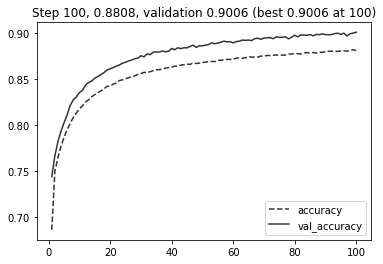

In [7]:
keras.backend.clear_session()

model = create_model(
    number_features=X_train.shape[1],
    number_classes=y_train.shape[1]
)

# четверть тренировочных оставим
# под валидацию
validation = int(train * 0.25)

model.fit(
    X_train[validation:], y_train[validation:],
    batch_size=1024,
    epochs=100,
    validation_data=(X_train[:validation], y_train[:validation]),
    verbose=0, # НЕ выводить информацию по ходу дела
    callbacks=[
        PlotLosses(metric='accuracy'),
        keras.callbacks.ModelCheckpoint(
            'models/covtypes.h5',
            monitor='val_accuracy',
            save_best_only=True
        )
    ]
);

In [8]:
# загрузим нашу лучшую отобранную по accuracy на валидации модель
best_model = keras.models.load_model('models/covtypes.h5')
'loss %.2f, accuracy %.2f' % tuple(best_model.evaluate(X_test, y_test))

116203/116203 [==============================] - 6s 48us/step


'loss 0.25, accuracy 0.90'

## Заключение

Видим, что метрика и дальше могла бы улучшаться, но с каждым шагом дальше это происходит всё медленнее, улучшение всё меньше. На диаграммах, подобных выше, сразу видно, переобучается модель (на тренировочных данных метрика сильно больше) или нет (тренировочные и валидационные данные дают схожие метрики).

Так же стоит отметить, что готовить данные для сетей и обучать их - дело не самое простое. Тем не менее, их "всеядность" в плане данных не оставляет иного выбора исследователям. И далее мы посмотрим, что еще могут такого нейросети, кроме и так нам понятных табличных данных.